# Model validation - BelgaLogos dataset
 
Let's now validate the model across the whole dataset. As evaluation is pretty slow with the brute-force matching,
we will use models specialised to each brand, rather than a general model that can assess every brand. This will naturally
supress the false-positive rate, so this must be kept in mind.

We start with some general initialisation:

In [1]:
import lib.load_data as ld
import lib.model as model
from lib.validation import study_matches
import cv2, os

# Read in the BelgaLogos dataset, filtered by acceptable bounding-boxes and 'OK' flag
metadata = ld.read_metadata()
metadata = ld.filter_by_boundingbox(metadata, 10, 800)
metadata = metadata[metadata.ok == True]

and write a function that generates results from `study_matches` for each brand, summarising them in a dictionary:

In [2]:
def validation_run(metadata, logo_set):
    """Perform a validation run over a list of logos, returning a results dictionary"""
    # Initialise a dictionary for results
    results_list = []
    for logo_name in logo_set:
        # Get the logo image
        logo_filename = os.path.join("data", "logos", logo_name.lower() + '.jpg')
        logo_image = cv2.imread(logo_filename)

        # Initialise model
        SIFT = cv2.xfeatures2d.SIFT_create()
        SIFTMatcher = model.KeypointMatcher(SIFT, cv2.NORM_L2SQR)
        SIFTMatcher.add_template(logo_name, logo_image)

        # Get target dataset
        dataset = metadata[(metadata.brand == logo_name)]

        #Perform study
        results_list.append(study_matches(dataset, SIFTMatcher))
    return results_list

Finally we initialise our brand lists and perform the validation runs

In [3]:
# Initialise a list of car and clothing logo brands
car_logos      = ["Citroen", "Citroen-text", "Ferrari", "Kia", "Mercedes", "Peugeot"]
clothing_logos = ["Adidas", "Adidas-text", "Airness", "Gucci", "Nike", "Puma", "Puma-text", "Reebok", "Umbro"]

In [4]:
%%time 
car_results = validation_run(metadata, car_logos) # Run over car logos

CPU times: user 11min 28s, sys: 35.8 s, total: 12min 4s
Wall time: 10min


In [5]:
%%time 
clothing_results = validation_run(metadata, clothing_logos) # Run over clothing logos

CPU times: user 11min, sys: 1min 15s, total: 12min 15s
Wall time: 9min 10s


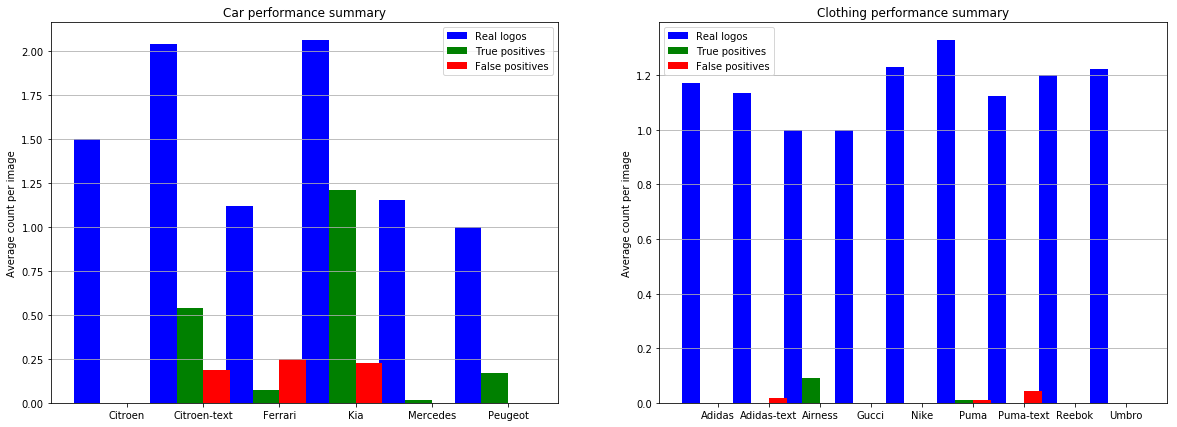

In [8]:
from lib.validation import validation_histogram
from matplotlib import pyplot as plt

# Plot validation histograms
fig, ax = plt.subplots(1, 2, figsize=(20,7))
validation_histogram(ax[0], car_results, car_logos, plot_label = "Car performance summary")
validation_histogram(ax[1], clothing_results, clothing_logos, plot_label = "Clothing performance summary")

These results show quite a variation in performance. For the car dataset, correct matches are found for the Citroen-text, Peugeot, Kia and Mercedes logos.
However for the most part, detection efficiency is low. Unsurprisingly Citroen results in no matches (as we saw in the ideal case). False-positive rates are in general fortunately low. For the clothing-brands case, there are barely any correct matches. Simmilarly to the Mercedes case, these images are particuarly challenging to detect as they are locating on warped clothing, something that keypoint-matching finds particuarly difficult.

Nonetheless there are positive signs, correct matches are identified for Airness and Puma, suggesting that with some tuning better results could be achieved.